In [1]:
import sys,os
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__)))) # 添加上层目录到 sys.path

from data_process import X_test,X_train,X_valid,y_test_master
from data_process import y_test,y_train,y_train_master,y_valid_master,y_valid
from data_process import X_valid_MCI,X_train_MCI,y_valid_MCI,y_train_MCI
# from dimension_reduction import X_train,X_valid,X_test
from dimension_reduction_lda import dimension_reduction,visualization
from train_and_test import train_and_test,device
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

{'AD': 0, 'MCI': 1, 'MCIn': 2, 'MCIp': 3, 'NC': 4}
random seed: 1696812380


In [72]:

# Encoder
class Encoder(nn.Module):
    """ Vanilla encoder with 3 fc layers 
    Args:
            dIn (int): Dim of input
        dHidden (int): Dim of intermediate FCs.
             dZ (int): Dim of z.
             
    Inputs:
        x (torch.FloatTensor): [N, d_origin]. Input images.
        
    Outputs:
        torch.FloatTensor: [N, dZ]. Latent variable z.
    """
    def __init__(self, dIn: int, dH1: int, dH2: int, dZ: int):
        super().__init__()
        # [fc -> relu -> bn] * 2 -> fc 
        self._net = nn.Sequential(
            nn.Linear(dIn, dH1),
            nn.LeakyReLU(),
            # nn.BatchNorm1d(dH1),
            nn.Linear(dH1, dH2),
            nn.LeakyReLU(),
            # nn.BatchNorm1d(dH2),
            nn.Linear(dH2, dZ)
        )
        
    def forward(self, x):
        return self._net(x)

In [73]:
# Decoder
class Decoder(nn.Module):
    """ Vanilla decoder with 3 fc layers 
    Args:
             dZ (int): Dim of z.
        dHidden (int): Dim of intermediate FCs.
             
    Inputs:
        z (torch.FloatTensor): [N, dZ]. Input latent variable z.
        
    Outputs:
        torch.FloatTensor: [N, channel, hw, hw]. xHat, restored x.
    """
    def __init__(self, dZ: int, dH2: int, dH1: int, dOut: int):
        super().__init__()
        # [fc -> relu -> bn] * 2 -> fc 
        self._net = nn.Sequential(
            nn.Linear(dZ, dH2),
            nn.LeakyReLU(),
            # nn.BatchNorm1d(dH2),
            nn.Linear(dH2, dH1),
            nn.LeakyReLU(),
            # nn.BatchNorm1d(dH1),
            nn.Linear(dH1, dOut),
            # Map output to [0, 1]
            nn.Sigmoid()
        )
        
    def forward(self, z):
        return self._net(z)

In [13]:
# def visualize(encoder: nn.Module, decoder: nn.Module, testInput: torch.Tensor, losses: [float]):
#         display.clear_output(wait=True)
#         xHat = decoder(encoder(testInput))
#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    
#         # 绘制xHat和testInput
#         ax1.plot(xHat, label='xHat')
#         ax1.plot(testInput, label='testInput')
#         ax1.legend()
#         ax1.grid(True)
        
#         # 绘制losses
#         ax2.plot(losses, label='Loss')
#         ax2.legend()
#         ax2.grid(True)
        
#         plt.show()

In [74]:
def train(encoder: nn.Module, decoder: nn.Module, trainDataset, testDataset, lossFn, lr = 0.001, step = 1000):
    ############### FOR VISUALIZATION, DO NOT CHANGE ###############
    # def visualize(encoder: nn.Module, decoder: nn.Module, losses: [float]):
    #     fig, ax = plt.subplots(figsize=(8, 6))
    #     ax.plot(losses)
    #     ax.set_xlabel("Iteration")
    #     ax.set_ylabel("Loss")
    #     ax.set_title("Loss Over Iterations")
    #     plt.grid(True)
    #     plt.show()
    #     # display.clear_output(wait=True)
    #     # xHat = decoder(encoder(testImages))
    #     # results = torch.cat([testImages, xHat], 0)
    #     # results = torchvision.utils.make_grid(results, nrow=4)
    #     # fig, ax2 = plt.subplots(1, 2, figsize=(15,5))
    #     # # results = results.permute(1, 2, 0)
    #     # # ax1.imshow(results)
    #     # # ax1.axis("off")
    #     # ax2.plot(losses)
    #     # ax2.grid(True)
    #     # plt.show()
    #     # # return results
    # # create Dataset loader
    def visualize(encoder: nn.Module, decoder: nn.Module, testInput: torch.Tensor, losses: [float]):
        # display.clear_output(wait=True)
        print(testInput.shape)
        testInput.unsqueeze_(0)
        xHat = decoder(encoder(testInput))
        print(xHat.shape)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    
        # 绘制xHat和testInput
        # ax1.plot(xHat, label='xHat')
        # ax1.plot(testInput, label='testInput')
        # # ax1.legend()
        # ax1.grid(True)
        
        # 绘制losses
        ax2.plot(losses, label='Loss')
        # ax2.legend()
        ax2.grid(True)
        
        plt.show()
    loader = torch.utils.data.DataLoader(trainDataset, batch_size=2, shuffle=True, num_workers=2)
    # create Optimizer
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr,weight_decay=0.9)
    
    # test images for visualization
    # testImgs = list()
    random_index = random.randint(0, len(testDataset) - 1)
    sample_data, _ = testDataset[random_index]
    # pick = random.sample(range(len(testDataset)), 4)
    # for i in pick:
    #     testImgs.append(testDataset[i][0])
    # testImgs = torch.stack(testImgs, 0)
    
    # loss logging
    losses = list()
    iterator = iter(loader)
    
    # all results
    # allImages = list()
    
    for i in range(step):
        try:
            x, _ = next(iterator)
        except StopIteration:
            iterator = iter(loader)
            x, _ = next(iterator)
        # encoding
        # print(x.shape)
        # print(f'x before assignment:{x.requires_grad}')
        if  x.requires_grad==False:
            x.requires_grad = True
        # print(f'x after assignment:{x.requires_grad}')
        z = encoder(x)
        # print(f'z before assignment: {z.requires_grad}')
        if  z.requires_grad==False:
            z.requires_grad=True
        # print(f'z after assignment: {z.requires_grad}')
        # decoding
        xHat = decoder(z)
        # compute reconstruction loss
        loss = lossFn(xHat, x)
        # log losses
        losses.append(loss.item())

        # gradient backward and step
        optimizer.zero_grad()
        # print(f'before loss.requires_grad:{loss.requires_grad}')
        if loss.requires_grad==False:
            loss.requires_grad=True
        # print(f'after loss.requires_grad:{loss.requires_grad}')
        loss.backward()
        optimizer.step()

        # visualize
        if i % 100 == 0:
            torch.set_grad_enabled(False)
            encoder.eval()
            decoder.eval()
            # allImages.append()
            visualize(encoder, decoder,sample_data, losses)
            encoder.train()
            decoder.train()
            torch.set_grad_enabled(True)
    # final
    print(f"Train on {step} steps finished.")
    print(f"Final loss: {loss.item()}")
    # return allImages

In [27]:
# X_train = torch.from_numpy(X_train).float()
# X_test = torch.from_numpy(X_test).float()
# y_train_master = torch.from_numpy(y_train_master).float()
# y_test_master = torch.from_numpy(y_test_master).float()
print(type(X_train))
train_dataset = torch.utils.data.TensorDataset(X_train,y_train_master)
test_dataset = torch.utils.data.TensorDataset(X_test,y_test_master)

<class 'torch.Tensor'>


In [28]:
print(X_train.shape[1])

186


In [62]:
H1=110
H2=80
dim=2
encoder, decoder = Encoder(X_train.shape[1], H1,H2, dim), Decoder(dim, H2,H1, X_train.shape[1])
# Encoder = Encoder(1, cHidden, cZ)
x = torch.rand(2, 186)
z = encoder(x)
print("Shape of \"z\":", list(z.shape))

# Decoder = Decoder(cZ, cHidden, 1)
xHat = decoder(z)
print("Shape of \"xHat\":", list(xHat.shape))
if xHat.shape != x.shape:
    raise ValueError("Oops! x and xHat don't have same shape")
else:
    print("Alright!")
# create encoder and decoder

for name, param in encoder.named_parameters():
    print(f"Parameter: {name}, requires_grad: {param.requires_grad}")
for name, param in decoder.named_parameters():
    print(f"Parameter: {name}, requires_grad: {param.requires_grad}")

Shape of "z": [2, 2]
Shape of "xHat": [2, 186]
Alright!
Parameter: _net.0.weight, requires_grad: True
Parameter: _net.0.bias, requires_grad: True
Parameter: _net.2.weight, requires_grad: True
Parameter: _net.2.bias, requires_grad: True
Parameter: _net.3.weight, requires_grad: True
Parameter: _net.3.bias, requires_grad: True
Parameter: _net.5.weight, requires_grad: True
Parameter: _net.5.bias, requires_grad: True
Parameter: _net.6.weight, requires_grad: True
Parameter: _net.6.bias, requires_grad: True
Parameter: _net.0.weight, requires_grad: True
Parameter: _net.0.bias, requires_grad: True
Parameter: _net.2.weight, requires_grad: True
Parameter: _net.2.bias, requires_grad: True
Parameter: _net.3.weight, requires_grad: True
Parameter: _net.3.bias, requires_grad: True
Parameter: _net.5.weight, requires_grad: True
Parameter: _net.5.bias, requires_grad: True
Parameter: _net.6.weight, requires_grad: True
Parameter: _net.6.bias, requires_grad: True


torch.Size([186])
torch.Size([1, 186])


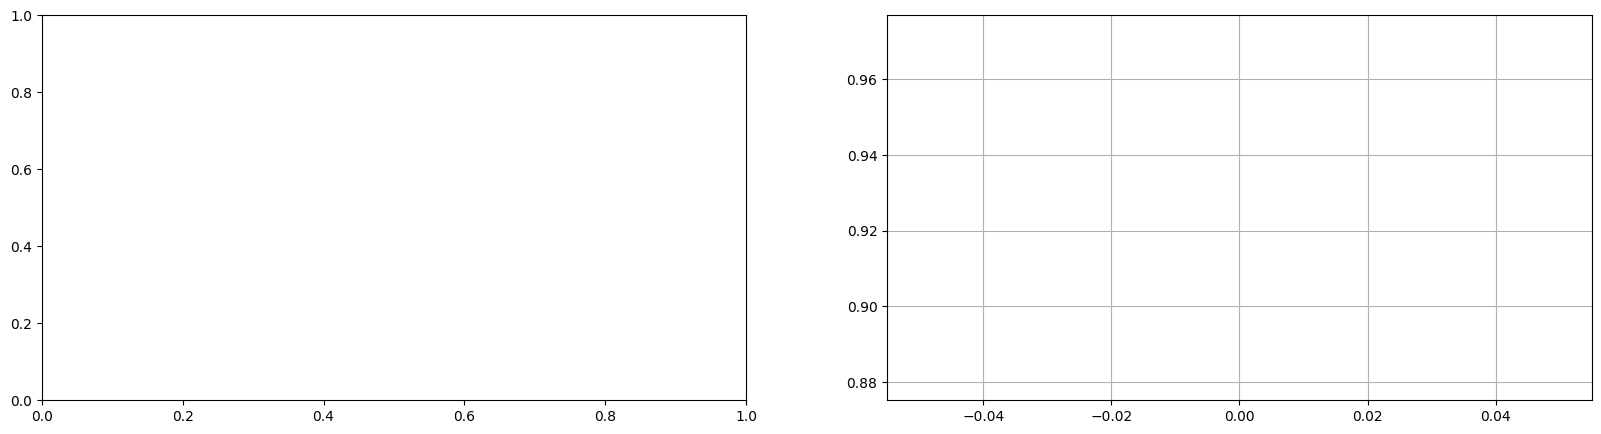

torch.Size([1, 186])


RuntimeError: running_mean should contain 1 elements not 110

In [75]:

# use `F.binary_cross_entropy` as loss function, learning rate = 0.0005, train steps = 6000
train(encoder, decoder, train_dataset, test_dataset, F.mse_loss, lr=0.0005, step=500)

In [ ]:
from sklearn.manifold import TSNE

# use t-SNE to reduce dim to 2D for plotting in 2D axes
def tsne(latents):
    return TSNE().fit_transform(latents)

# pick all latents and corresponding labels
@torch.no_grad()
def collectLatent(encoder: nn.Module, dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)
    
    latents = list()
    labels = list()
    

    for x, label in loader:
        # get z ([N, 20]) from encoder
        latent = encoder(x)
        print(latent.shape)
        # append to latents
        latents.append(latent)
        # append label to labels
        labels.append(label)
        
    
    # latents: list of [N, 20], labels: list of [N]
    return torch.cat(latents, 0).numpy(), torch.cat(labels, 0).numpy()

# plot latents in 2D figure
def visualizeLatent(latents, labels):
    # [N, 2]
    # reduced = tsne(latents)
    fig = plt.figure(figsize=(10,10), facecolor='w', edgecolor='k')
    plt.axis("off")
    # plot reduced-latent on figure and colored by labels
    # plt.scatter(reduced[:, 0], reduced[:, 1], s=4, c=labels)
    plt.scatter(latents[:, 0], latents[:, 1], s=4, c=labels)

torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([

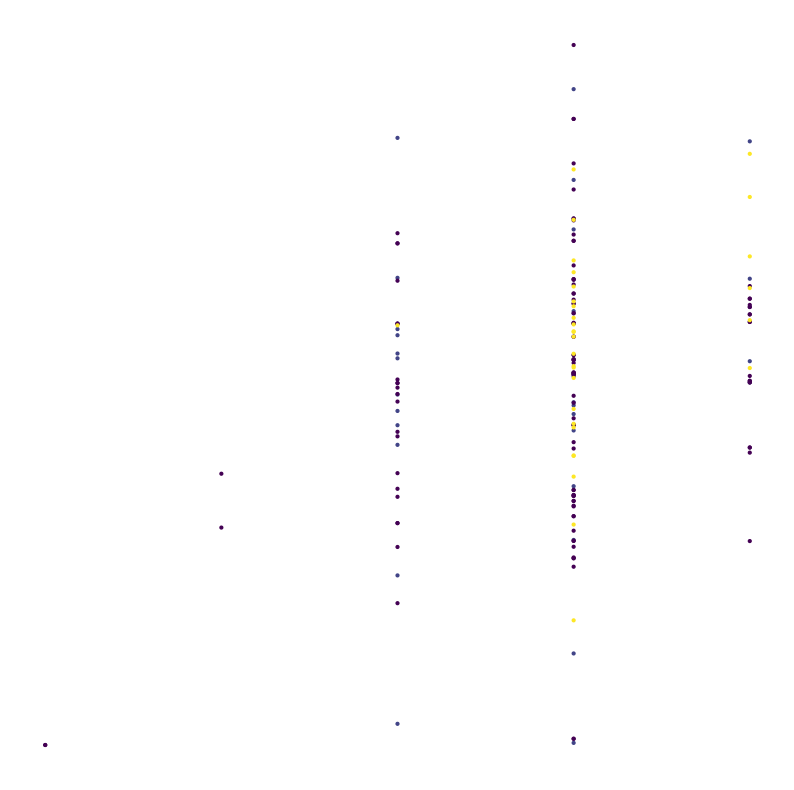

In [ ]:
# print("Collecting latent......")
latents, labels = collectLatent(encoder, train_dataset)
# print("Computing tSNE......")
# print("This is slow......")
visualizeLatent(latents, labels)